# Covid-19 contagion, economic activity and business reopening protocols

### Alexandre Janiak, Caio Machado and Javier Turen

This notebook numerically solves the model in Janiak, Machado and Turen (2020) and presents some additional results that are not in the paper.

# 1. Numerical solution of the model

In [1]:
using DifferentialEquations, Parameters, NLsolve, LinearAlgebra, Statistics, Plots, PGFPlotsX, LaTeXStrings
gr(linewidth = 2);

## 1.1. Parameters

Those are the model parameters:

In [2]:
@with_kw struct Para

    ### Technology and preferences
    N::Int32                                     # Number of sectors
    θ::Vector{Float64}                           # Vector 1xN with income share of each sector
    α::Vector{Float64}                           # Vector 1xN with Cobb-Douglas parameter
    albar::Vector{Float64}                       # Vector 1xN with scale parameter of Pareto distribution
    ϵ::Vector{Float64}                           # Vector 1xN with shape parameter of Pareto distribution
    m::Vector{Float64}                           # Vector 1xN with each group mass
    χ::Vector{Float64}                           # Vector 1xN with fixed cost
    ρ::Float64                                   # Discount rate

    ### Parameters SIR
    ν::Float64                                   # Mortalility rate
    γ::Float64                                   # Rate of exit infected
    δ::Float64                                   # Rate of exit resolving
    ξ::Float64 = 0.0                             # Rate of leisure contact
    ω::Vector{Float64} = ones(N)                 # Vector 1xN with conditional share of workers matched 

    ### Protocol dependent parameters
    τ::Vector{Float64} = ones(N)                 # Vector 1xN with variable protocol costs
    η::Vector{Float64} = zeros(N)                # Vector 1xN with fixed costs of protols
    φ::Vector{Float64} = zeros(N)                # Vector 1xN with ϕ's (consumption contagion)

    ### Parameters of the ODE solver
    dt::Float64 = 0.1                            # Time step to save ODE solution

    ### Functions of parameters
    Ω::Vector{Float64} = @. α^(α/(1-α))-α^(1/(1-α))
    zww::Vector{Float64} = ω .^ 2
    zcc::Vector{Float64} = (1 .- ω) .^ 2
    zwc::Vector{Float64} = 1 .- zww .- zcc

end;

# z's as a function of ω for future reference 
# Parameters.jl will not update z's automatically, so we need to use this when change the ω's
function zfun(ω)
    zww = ω .^ 2
    zcc = (1 .- ω) .^ 2
    zwc = 1 .- zww .- zcc
    return zww, zcc, zwc
end;

We provided defaults to some parameters because it is convenient during the calibration.

## 1.2. Economic block

We define a function that returns consumption $(c_1,c_2,...,c_N)$ as a function of $(L_1,L_2,...,L_N)$ and parameters:

In [3]:
function cfun(L,p)
    @unpack ϵ, albar, α, χ, η, τ, Ω = p
    astar = @. albar*(((χ+η)/L)*((((α)^(1/(1-α)))/Ω)*(ϵ/(ϵ-1/(1-α)))+1))^(1/ϵ)
    astar = max.(astar,albar)
    consumption = @. (ϵ/(ϵ-1/(1-α)))*(albar^ϵ)*(astar^(1-ϵ))*(α*(χ+η)/(Ω*τ))^α
end;

Remark: Note that `astar` is replaced by `albar` whenever `astar` is below `albar` in the function above, so  `astar[j]` it is not exactly the same as $a^*_j$ in the paper (but is convenient to redefine it like that in the code).

## 1.3. Epidemiological block

The system is represented by a vector
$$u_t = (S_{1t},...,S_{Nt},I_{1t},...,I_{Nt},R_{1t},...,R_{Nt},V_{1t},...,V_{Nt},D_{1t},...,D_{Nt})$$
We now define a function to return $\beta_{ji}$ in a matrix, using the equilibrium consumption:

In [4]:
function betafun(u,p)
    @unpack zww, zwc, zcc, φ, ξ, N = p

    # Labor supply Aj=Sj+Ij+Vj for each sector and total active population:
    A = [u[i] + u[N+i] + u[3*N+i] for i=1:N]
    Abar = sum(A)

    # Aggregate consumption for each sector:
    c = cfun(A,p)

    # Total contacts during consumption:
    CC = sum([2*φ[k]*c[k]*zcc[k]/Abar for k=1:N])

    # Computes matrix β:
    β = [(A[i]/Abar)*(CC + φ[j]*c[j]*zwc[j]/A[j] + ξ) + φ[i]*c[i]*zwc[i]/Abar for j=1:N, i=1:N]
    for j=1:N
        β[j,j] = β[j,j] + 2*φ[j]*c[j]*zww[j]/A[j] # Updates matrix when workers are in the same sector
    end
    return β, A
end;

Note that `β[j,i]` denotes the rate at which agents of sector $j$ meet agents of sector $i$. Finally, we can define the law of motion:

In [5]:
function f!(du,u,p,t)
    @unpack γ, δ, ν, N = p
    β, A = betafun(u,p)

    # Meetings with infected agents for agents of each sector j:
    aux = [sum([β[j,i]*(u[N+i]/A[i]) for i=1:N]) for j=1:N]

    for j=1:N
        du[j] = -u[j]*aux[j]                    # Law of motion for Susceptible
        du[N+j] = u[j]*aux[j] - γ*u[N+j]        # Law of motion for Infected
        du[2*N+j] = γ*u[N+j] - δ*u[2*N+j]       # Law of motion for Resolving
        du[3*N+j] = (1-ν)*δ*u[2*N+j]            # Law of motion for recoVered
        du[4*N+j] = ν*δ*u[2*N+j]                # Law of motion for Deceased
    end
end;

## 1.4. Solving the two blocks

The next function computes the solution a given set of parameters, initial conditions  and time span. Initial conditions should be a vector $u_0 = (S_{10},...,S_{N0},I_{10},...,I_{N0},R_{10},...,R_{N0},V_{10},...,V_{N0},D_{10},...,D_{N0})$. The time span is a list like `tspan=(0,240)`.

In [6]:
function compute_equilibrium(p,u0,tspan)

    # Solving the system of ODEs
    prob = ODEProblem(f!,u0,tspan,p)
    sol = solve(prob,saveat=p.dt,abstol = 1e-9, reltol = 1e-9);

    @unpack ϵ, albar, α, χ, η, τ, Ω, θ, dt, ρ, N = p

    # Array with labor supply A = S+I+V in each sector at each date t
    L = [[sol[i,t] + sol[N+i,t] + sol[3*N+i,t] for i=1:N] for t=1:length(sol.t)]

    # Consumption of each good at each date t
    Consumption = [cfun(L[t],p) for  t=1:length(sol.t)]

    # Log output at each date t
    Output = [prod(Consumption[t].^θ) for t=1:length(sol.t)]

    # Discounted utility
    Utility = sum(Output.*dt.*exp.(-ρ*sol.t))

    # Cutoff astar
    astar = [[albar[i]*(((χ[i]+η[i])./L[t][i])*((((α[i])^(1/(1-α[i])))/Ω[i])*(ϵ[i]/(ϵ[i]-1/(1-α[i])))+1))^(1/ϵ[i]) 
            for t=1:length(sol.t)] for i=1:N]
    astar = [max.(astar[i],ones(length(sol.t))*albar[i]) for i=1:N]

    # Mass of operating firms
    MassOperating = [(albar[i] ./ astar[i]).^ϵ[i] for i=1:N]

    # Average productivity
    MeanProductivity = [((ϵ[i]/(ϵ[i]-1/(1-α[i])))^(1-α[i]))*astar[i] for i=1:N]

    # Wage over price
    WagePrice = [[((ϵ[i]/(ϵ[i]-1/(1-α[i])))^(1-α[i]))*((L[t][i]*(astar[i][t]/albar[i])^ϵ[i]-χ[i]-η[i])^(α[i]-1))*((astar[i][t]*α[i])/(τ[i]^α[i])) 
                for t=1:length(sol.t)] for i=1:N]

    # Average employment
    MeanEmployment = [((1 ./ WagePrice[i]).*(MeanProductivity[i]*α[i])/(τ[i]^α[i])).^(1/(1-α[i])) for i=1:N] 

    # Average production
    MeanProduction = [(MeanProductivity[i].^(1/(1-α[i]))).*(((1 ./ WagePrice[i])*(α[i]/τ[i])).^(α[i]/(1-α[i]))) for i=1:N]

    # Susceptible, Infected, Resolving, recoVered, Deceased 
    S = zeros(length(sol.t))
    I = S ; R = S ; V = S ; D = S
    for i=1:p.N
        S = S + sol[i,:]
        I = I + sol[p.N+i,:]
        R = R + sol[2*p.N+i,:]
        V = V + sol[3*p.N+i,:]
        D = D + sol[4*p.N+i,:]
    end

    out = (sol=sol, Time=sol.t, Consumption=Consumption, Output=Output, Utility=Utility, S=S, I=I, R=R, V=V, D=D, 
           astar=astar, MeanProductivity=MeanProductivity, MassOperating=MassOperating, WagePrice=WagePrice,
           MeanEmployment=MeanEmployment, MeanProduction=MeanProduction)
end;

# 2. Calibration

Those are the parameters calibrated independently of the dynamics in the model:

In [7]:
N = 10
albar = ones(N)
α = 0.85*ones(N)
χ = [6.6413;17.3989;8.7136;6.7824;6.5349;6.4695;15.208;5.0803;9.1444;28.1434]
ϵ = [13.23593117;13.56738732;11.50387924;14.19816999;12.58169958;12.20681809;11.50142937;13.14097029;12.56335519;15.14999533]
θ = [0.023873;0.1842649;0.0743015;0.0289043;0.1175122;0.104245;0.3831015;0.0559524;0.0130433;0.0148018]
τ = [1.054860845;1.028816915;1.056575841;1.073051873;1.046783619;1.060175776;1.039915238;1.050875301;1.03857301;1.023862186]
η = [1.171282163;0.61524276;1.207897406;1.559661625;0.998832928;1.284756224;0.852192591;1.086190559;0.82353596;0.509459021]
m = [0.040612229;0.346944009;0.075600034;0.021920943;0.099010146;0.101335907;0.211769547;0.062562137;0.032150887;0.008094162]
ν = 0.01
γ = 0.2
ρ = 0.04/365
δ = 0.1
h = [0.277844758;0.263612759;0.1341312;0.09127997;0.09026727;0.053709625;0.04098018;0.026837728;0.014559845;0.006776665]
q = 1.63541796
sw = [0.244389381;0.271713741;0.388558488;0.285224295;0.439085099;0.361899252;0.35048772;0.203665125;0.203665125;0.601849484];

If we know $h$, $q$, $s^w$ and $\xi$ we can determine $\phi=(\phi_1,\phi_2,...,\phi_N)$ and then $\omega=(\omega_1,\omega_2,...,\omega_N)$ (after computing consumption in a steady state). The next function gives this map:

In [8]:
function phiomegafun(h,q,sw,ξ,p)
    # Computes cbar:
    cbar = cfun(p.m,p)
    Φ = q*ξ # Computes Φ
    φ = (Φ*h)./cbar # Computes ϕ
    f(ω) = @. sw - (2*φ*cbar*ω/p.m)/(2*φ*cbar*ω/p.m+2*sum((1-ω)*φ*cbar) + ξ)
    ω = nlsolve(f, 0.5*ones(p.N)).zero
    return φ, ω
end;

Hence, all that is left is to calibrate the parameter $\xi$. To calibrate $\xi$ we will target a particular growth rate of infected at the beginning of the pandemic, which is given by the following function (note that we also compute the growth rate of cumulative cases and deaths):

In [9]:
function InfectedGrowth(h,q,sw,ξ,u0,tspan,p)
    φ, ω = phiomegafun(h,q,sw,ξ,p)
    zww, zcc, zwc = zfun(ω)
    pnew = reconstruct(p,ξ=ξ,φ=φ,ω=ω,zww=zww,zcc=zcc,zwc=zwc) # Replaces ξ, ϕ and ω in current set of parameters
    out = compute_equilibrium(pnew,u0,tspan) # Solves ODE system

    # Computes growth rate of infections, total cases and deaths
    GrowthRate = [(out.I[t+1]-out.I[t])/(p.dt*out.I[t]) for t=1:length(out.Time)-1]
    TotalCases = 1.0 .- out.S
    GrowthRateTotal = [(TotalCases[t+1]-TotalCases[t])/(p.dt*TotalCases[t]) for t=1:length(out.Time)-1]
    GrowthRateDeaths = [(out.D[t+1]-out.D[t])/(p.dt*out.D[t]) for t=1:length(out.Time)-1]
    return mean(GrowthRate), mean(GrowthRateTotal), mean(GrowthRateDeaths[2:end]) # We exclude first growth rate of deaths, as it is usually Inf
 end;

Now we are ready to find $\xi$. Let's change this cell by hand until we get an average growth rate of infected of 14% in the first 30 days of the pandemic, as explained in the paper (we can use a non-linear solver too). To start a pandemic in the model, we assume here that initially a small fraction of the population has the virus.

In [10]:
ξ = 0.0795
p = Para(ν=ν, γ=γ, δ=δ, N=N, θ=θ, α=α, albar=albar, ϵ=ϵ, m=m, χ=χ, ρ=ρ, ξ=ξ) # Parameters without protocols
u0aux = [[0.9999;ones(N-1)].*p.m;[0.0001;zeros(N-1)].*p.m;zeros(3*p.N)] # Initial conditions to compute growh rate of I
tspanaux = (0.0,30) # What is called "beginning of the pandemic"
InfectedGrowth(h,q,sw,ξ,u0aux,tspanaux,p)

(0.1409488760491084, 0.1707603131926086, 0.5244757218890301)

Just to make sure the growth rate of infected is near constant at the beginning of the pandemic, we plot it using the found $\xi$ (we also plot the growth rate of cumulative cases and deaths):

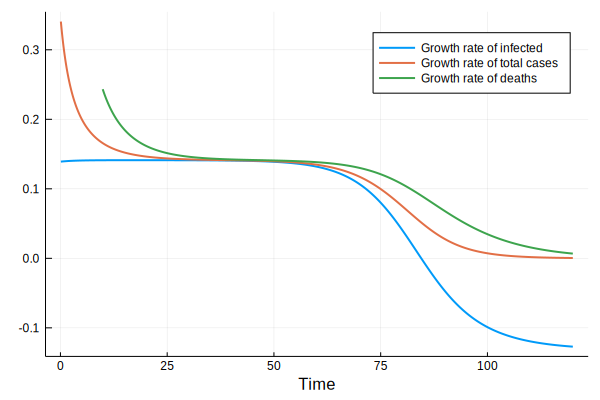

In [11]:
φaux, ωaux = phiomegafun(h,q,sw,ξ,p) # Define values of ϕ and ω given the found ξ
zwwaux, zccaux, zwcaux = zfun(ωaux)
paux = reconstruct(p,φ=φaux,ω=ωaux,zww=zwwaux,zcc=zccaux,zwc=zwcaux)
tspanaux = (0.0,120.0); # Time span for simulations
outaux = compute_equilibrium(paux,u0aux,tspanaux)
GrowthRate = [(outaux.I[t+1]-outaux.I[t])/(paux.dt*outaux.I[t]) for t=1:length(outaux.Time)-1]
GrowthRateDeaths = [(outaux.D[t+1]-outaux.D[t])/(paux.dt*outaux.D[t]) for t=1:length(outaux.Time)-1]
TotalCases = 1.0 .- outaux.S
GrowthRateTotal = [(TotalCases[t+1]-TotalCases[t])/(p.dt*TotalCases[t]) for t=1:length(outaux.Time)-1]
plot(outaux.Time[2:end],GrowthRate,label="Growth rate of infected", xlabel = "Time")
plot!(outaux.Time[2:end],GrowthRateTotal,label="Growth rate of total cases")
plot!(outaux.Time[Int(round(10/paux.dt)):end],GrowthRateDeaths[Int(round(10/paux.dt))-1:end],label="Growth rate of deaths") # For deaths we don't plot the first days

Now we save our parameters without protocols in place:

In [12]:
φ, ω = phiomegafun(h,q,sw,ξ,p) # Define values of ϕ and ω given the found ξ
zww, zcc, zwc  = zfun(ω) 
p_np = reconstruct(p, φ=φ, ω=ω, zww=zww, zcc=zcc, zwc=zwc);

We construct several scenarios regarding how effective protocols are at reducing the social contacts created by firms. In particular, we assume a reduction of 0%, 15%, 30%, 50% and 100% in contagion. We save the parameters with protocols in each scenario:

In [13]:
p_p0 = reconstruct(p_np, τ=τ, η=η)
p_p15 = reconstruct(p_np, φ=φ*0.85, τ=τ, η=η)
p_p30 = reconstruct(p_np, φ=φ*0.7, τ=τ, η=η)
p_p50 = reconstruct(p_np, φ=φ*0.5, τ=τ, η=η)
p_p100 = reconstruct(p_np, φ=φ*0, τ=τ, η=η);

# 3. Results of simulations

Those are the initial conditions used:

In [14]:
s_I = 0.052/100
s_D = 0.063/100
s_V = 2.63/100
s_R = 0.1/100
s_S = 1-s_I-s_D-s_V-s_R
u0 = [s_S*m;s_I*m;s_R*m;s_V*m;s_D*m]; # Initial conditions

Since we assume that in 9 months an vaccine will arrive and the economy will go to a steady state without the virus we set the time span of the simulations equal to:

In [15]:
tspan = (0.0,270.0);

## 3.1. Wide protocols

And now we can finally solve the model under the scenarios constructed for economy-wide protocols:

In [16]:
out_np = compute_equilibrium(p_np,u0,tspan)
out_p0 = compute_equilibrium(p_p0,u0,tspan)
out_p15 = compute_equilibrium(p_p15,u0,tspan)
out_p30 = compute_equilibrium(p_p30,u0,tspan)
out_p50 = compute_equilibrium(p_p50,u0,tspan)
out_p100 = compute_equilibrium(p_p100,u0,tspan);

We also compute an additional scenario without pandemic and protocols to use in some graphs:

In [17]:
out_ss = compute_equilibrium(p_np,[m;0*m;0*m;0*m;0*m],tspan);

The consumption equivalent loss (during the pre-vaccine period) of each protocol is:

In [18]:
println(100*(out_np.Utility-out_p0.Utility)/out_np.Utility)
println(100*(out_np.Utility-out_p15.Utility)/out_np.Utility)
println(100*(out_np.Utility-out_p30.Utility)/out_np.Utility)
println(100*(out_np.Utility-out_p50.Utility)/out_np.Utility)
println(100*(out_np.Utility-out_p100.Utility)/out_np.Utility)

4.048524755627515
3.461996242696612
2.592247095247771
1.1595885013158294
1.092630723075161


The total deaths are:

In [19]:
println(out_np.D[end])
println(out_p0.D[end])
println(out_p15.D[end])
println(out_p30.D[end])
println(out_p50.D[end])
println(out_p100.D[end])

0.008192109419935981
0.007866502462502619
0.006536228564050948
0.004507700217283089
0.0008214488428831226
0.0006484783822947816


Now we generate some plots.

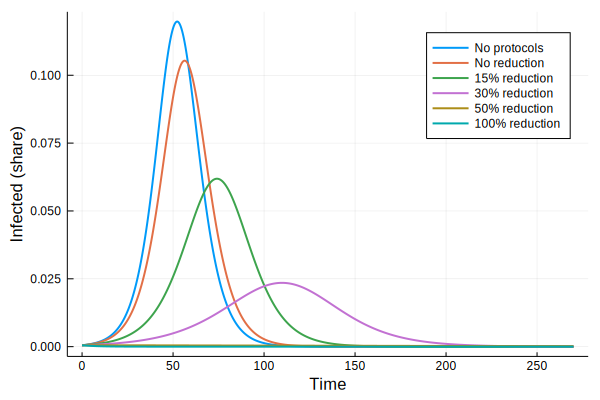

In [20]:
plot(out_np.Time, out_np.I, label="No protocols", xlabel="Time", ylabel="Infected (share)")
plot!(out_p0.Time, out_p0.I, label="No reduction")
plot!(out_p15.Time, out_p15.I, label="15% reduction")
plot!(out_p30.Time, out_p30.I, label="30% reduction")
plot!(out_p50.Time, out_p50.I, label="50% reduction")
plot!(out_p100.Time, out_p100.I, label="100% reduction")

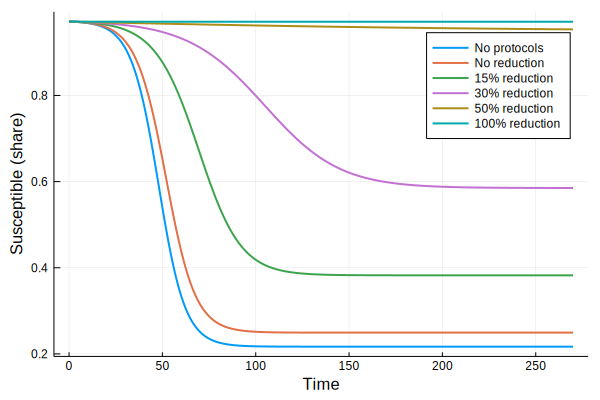

In [21]:
plot(out_np.Time, out_np.S, label="No protocols", xlabel="Time", ylabel="Susceptible (share)")
plot!(out_p0.Time, out_p0.S, label="No reduction")
plot!(out_p15.Time, out_p15.S, label="15% reduction")
plot!(out_p30.Time, out_p30.S, label="30% reduction")
plot!(out_p50.Time, out_p50.S, label="50% reduction")
plot!(out_p100.Time, out_p100.S, label="100% reduction")

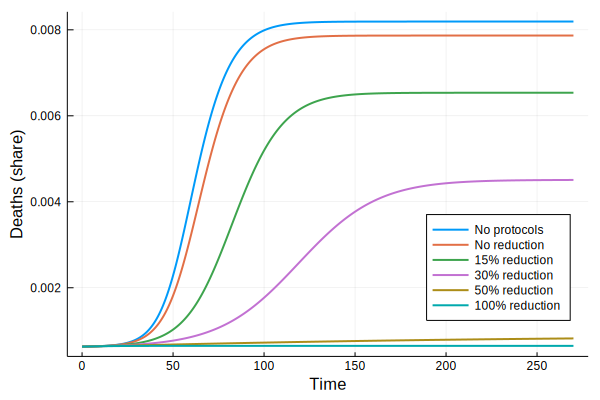

In [22]:
plot(out_np.Time, out_np.D, label="No protocols", xlabel="Time", ylabel="Deaths (share)", legend=:bottomright)
plot!(out_p0.Time, out_p0.D, label="No reduction")
plot!(out_p15.Time, out_p15.D, label="15% reduction")
plot!(out_p30.Time, out_p30.D, label="30% reduction")
plot!(out_p50.Time, out_p50.D, label="50% reduction")
plot!(out_p100.Time, out_p100.D, label="100% reduction")

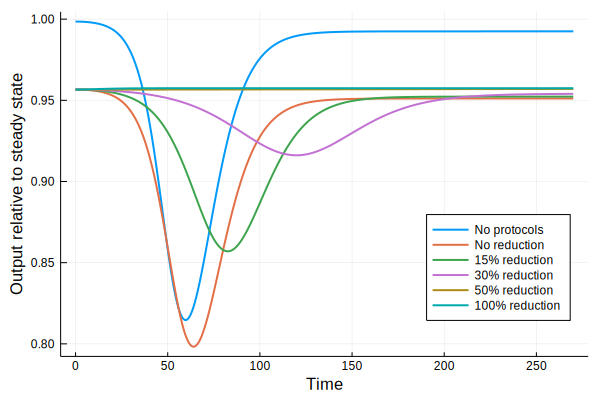

In [23]:
yss = out_ss.Output[1]
plot(out_np.Time, out_np.Output/yss, label="No protocols", xlabel="Time", ylabel="Output relative to steady state", legend=:bottomright)
plot!(out_p0.Time, out_p0.Output/yss, label="No reduction")
plot!(out_p15.Time, out_p15.Output/yss, label="15% reduction")
plot!(out_p30.Time, out_p30.Output/yss, label="30% reduction")
plot!(out_p50.Time, out_p50.Output/yss, label="50% reduction")
plot!(out_p100.Time, out_p100.Output/yss, label="100% reduction")

We also compute total deaths and consumption equivalent losses assuming different reductions in contagion by protocols:

In [24]:
Reduction = range(0,1,length=100)
DeathsMany = Vector{Float64}(undef,100)
CLossMany = Vector{Float64}(undef,100)

for i in eachindex(Reduction)
    p_r = reconstruct(p_np, φ=φ*(1-Reduction[i]), τ=τ, η=η)
    out_r = compute_equilibrium(p_r,u0,tspan)
    DeathsMany[i] = out_r.D[end]
    CLossMany[i] = 100*(out_np.Utility-out_r.Utility)/out_np.Utility        
end

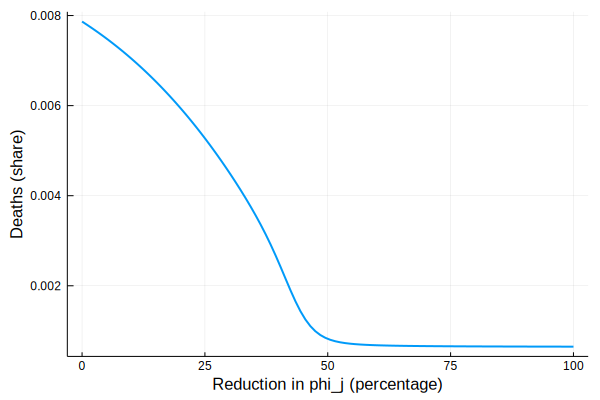

In [25]:
plot(100*Reduction, DeathsMany, xlabel="Reduction in phi_j (percentage)", ylabel="Deaths (share)", legend=false)

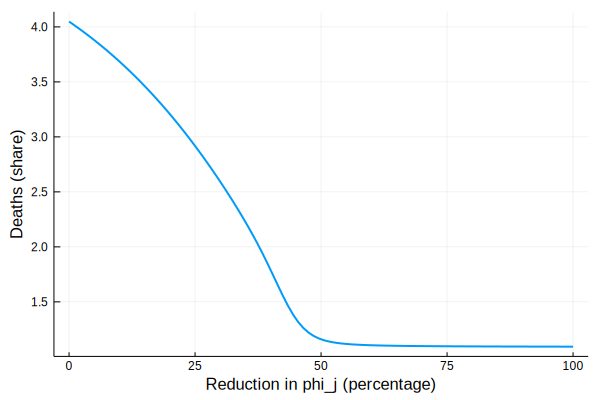

In [26]:
plot(100*Reduction, CLossMany, xlabel="Reduction in phi_j (percentage)", ylabel="Deaths (share)", legend=false)

## 3.2. Targeted protocols

Now we assume protocols are targeted to the 6 sectors with the highest exposure in our model and compare to the outcome we had with the one-size-fits-all policy. We will assume that protocols reduce contagion by half.

In [27]:
p_pt = reconstruct(p_p50, φ=[1/2*ones(6);ones(N-6)].*φ, τ=[τ[1:6];ones(N-6)], η=[η[1:6];zeros(N-6)])
out_pt = compute_equilibrium(p_pt,u0,tspan);

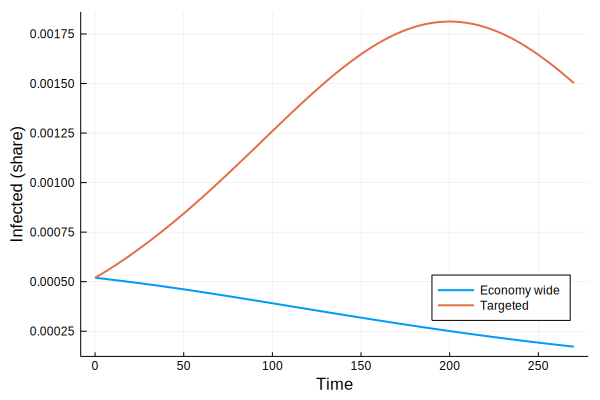

In [28]:
plot(out_p50.Time, out_p50.I, label="Economy wide", xlabel="Time", ylabel="Infected (share)",legend=:bottomright)
plot!(out_pt.Time, out_pt.I, label="Targeted")

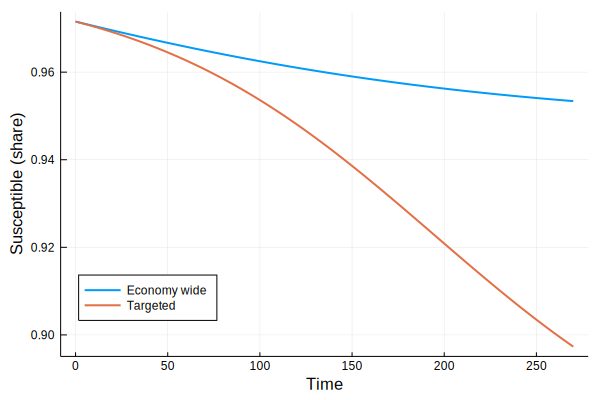

In [29]:
plot(out_p50.Time, out_p50.S, label="Economy wide", xlabel="Time", ylabel="Susceptible (share)", legend=:bottomleft)
plot!(out_pt.Time, out_pt.S, label="Targeted")

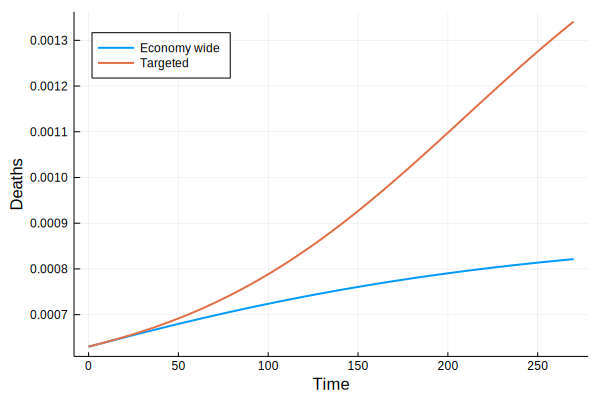

In [30]:
plot(out_p50.Time, out_p50.D, label="Economy wide", xlabel="Time", ylabel="Deaths", legend=:topleft)
plot!(out_pt.Time, out_pt.D, label="Targeted")

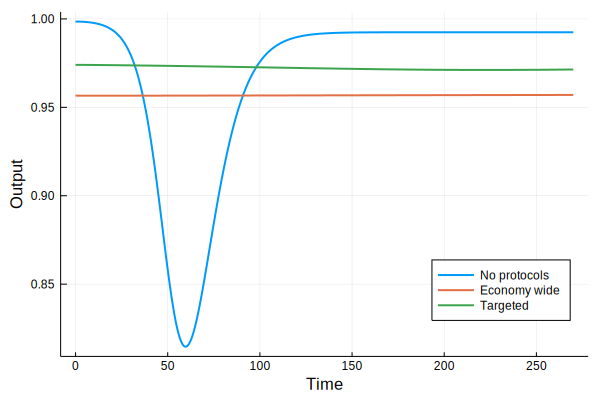

In [31]:
plot(out_np.Time, out_np.Output/yss, label="No protocols", xlabel="Time", ylabel="Output", legend=:bottomright)
plot!(out_p50.Time, out_p50.Output/yss, label="Economy wide")
plot!(out_pt.Time, out_pt.Output/yss, label="Targeted")

The consumption equivalent loss of targeted protocols is:

In [32]:
100*(out_np.Utility-out_pt.Utility)/out_np.Utility

-0.44026323254151173

Now we simulate 10 scenarios: Protocols in sector 1, protocols sector 1 and 2, in sectors 2, 3 and 4, etc, and plot the deaths and consumption equivalent losses:

In [33]:
DeathsTarg = zeros(N)
CLossTarg = zeros(N)
for i=1:N
    p_aux = reconstruct(p_p50, φ=[1/2*ones(i);ones(N-i)].*φ, τ=[τ[1:i];ones(N-i)], η=[η[1:i];zeros(N-i)])
    out_aux = compute_equilibrium(p_aux,u0,tspan)
    DeathsTarg[i] = out_aux.D[end]
    CLossTarg[i] = 100*(out_np.Utility-out_aux.Utility)/out_np.Utility
end
DeathsTarg = [out_np.D[end];DeathsTarg] # Add no protocols to the vector
CLossTarg = [0.0;CLossTarg];

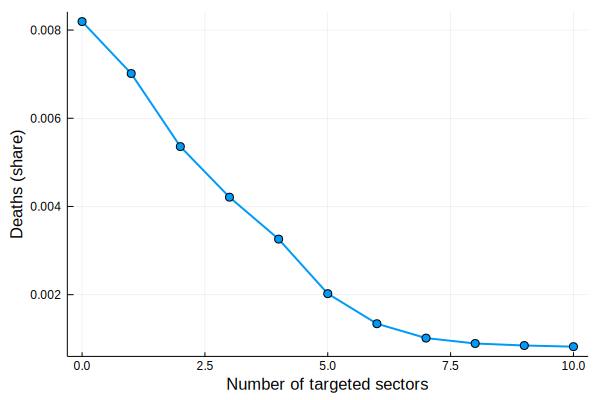

In [34]:
plot([0:1:N],DeathsTarg, xlabel="Number of targeted sectors", ylabel="Deaths (share)", legend=false, markershape=:circle)

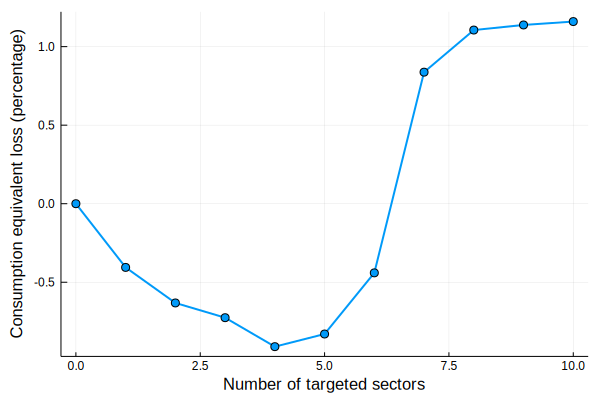

In [35]:
plot([0:1:N],CLossTarg, xlabel="Number of targeted sectors", ylabel="Consumption equivalent loss (percentage)", legend=false, markershape=:circle)

This is the menu of deaths and economic losses implied by these 10 policies:

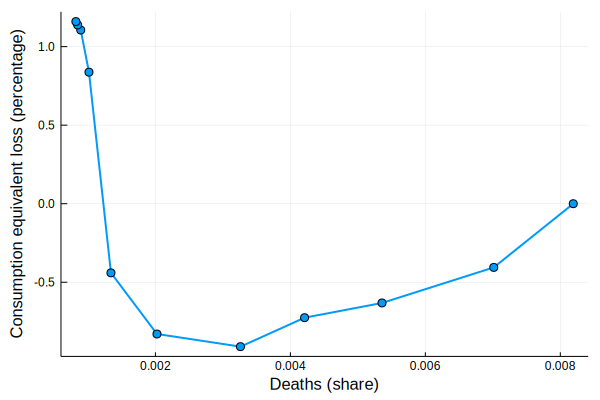

In [36]:
plot(DeathsTarg,CLossTarg, xlabel="Deaths (share)", ylabel="Consumption equivalent loss (percentage)", legend=false, markershape=:circle)

# 3.3. Economy wide weaker protocols vs targeted  stronger protocols

Now we proceed with a small extension that will allow us to show some policies that are dominated. We introduce a variable $\zeta_i \in (0,1)$ for each sector that represents the intensity of protocol requirements. We then assume that:

$$\tau = 1+\zeta_i (\tau_p-1)$$
$$\eta = \zeta_i \eta_p$$
$$\phi = \zeta_i \phi_p + (1-\zeta_i)\phi_{np}$$

Where the variables with subscript $p$ represent the values of a corresponding scenario with protocols in Section 3.1. The variables with subscript $np$ are the corresponding values without protocols. This implies that if $\zeta_i = 1$ we are imposing the same protocols for sector $i$ as in Section 3.1. If $\zeta_i=0$ we are back to the case of no protocols.

Now we create a function that returns household utility and deaths in for a given vector $\zeta = (\zeta_1,\zeta_2,...,\zeta_N)$.

In [37]:
function PartialProtocols(p_p,p_np,u0,tspan,ζ)
    τ = @. 1 + ζ*(p_p.τ-1)
    η = @. ζ*p_p.η
    φ = @. ζ*p_p.φ + (1-ζ)*p_np.φ
    p_aux = reconstruct(p_p, τ=τ, η=η, φ=φ)
    out_aux = compute_equilibrium(p_aux,u0,tspan)
    return out_aux.Utility, out_aux.D[end]
end;

Let's see what we get with an uniform policy of partial protocol $\zeta = (1/2,1/2,...,1/2)$, using the intermediate scenario that reduces $\phi_j$ in 50% of Section 3 as the benchmark when $\zeta_i = 1$.

In [38]:
PartialProtocols(p_p50,p_np,u0,tspan,1/2*ones(N))

(69.44061653337694, 0.005529075303722271)

Let's compare with the full protocol only in sectors 1, 2 and 3.

In [39]:
PartialProtocols(p_p50,p_np,u0,tspan,[ones(3);zeros(N-3)])

(70.620843398442, 0.004210405410438244)

This example shows a case in which an economy wide weak protocol is Pareto dominated by a strong but targeted protocol (we get more output and less deaths).